# Load one  and start training (see below to read presaved data)

In [ ]:
import os
import mne
from eegdash import EEGDash
from eegdash import EEGDashDataset

eegdash_braindecode = EEGDashDataset({'dataset': 'ds005514', 'task': 'RestingState', 'subject': 'NDARDB033FW5'}, description_fields=['sex'])

/Users/arno/Python/EEG-Dash-Data/src/eegdash/data_utils.py:51: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  self.raw = mne_bids.read_raw_bids(self.bidspath, verbose=False)
/Users/arno/Python/EEG-Dash-Data/src/eegdash/data_utils.py:51: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  self.raw = mne_bids.read_raw_bids(self.bidspath, verbose=False)
/Users/arno/Python/EEG-Dash-Data/src/eegdash/data_utils.py:51: RuntimeWarning: Unable to map the following column(s) to to MNE:
release_number: R9
ehq_total: -86.71
commercial_use: Yes
full_pheno: No
p_factor: 0.502
attention: -0.467
internalizing: 0.408
externalizing: 0.741
RestingState: available
DespicableMe: available
FunwithFractals: available
ThePresent: available
DiaryOfAWimpyKid: available
contrastChangeDetection_1: available
contrastChangeDetection_2: 

In [25]:
res = eegdash_braindecode.datasets[0][0]

In [26]:
from braindecode.preprocessing import (preprocess, Preprocessor, create_windows_from_events)
import mne
import numpy as np

class hbn_ec_ec_reanotation(Preprocessor):
    def __init__(self):
        super().__init__(fn=self.transform, apply_on_array=False)  # Pass the transform method as the function
    
    def transform(self, raw):  # Changed from 'apply' to 'transform'
        # Create events array from annotations
        events, event_id = mne.events_from_annotations(raw)
        
        print(event_id)

        # Create new events array for 2-second segments
        new_events = []
        sfreq = raw.info['sfreq']
        for event in events[events[:, 2] == event_id['instructed_toCloseEyes']]:
            # For each original event, create events every 2 seconds from 15s to 29s after
            start_times = event[0] + np.arange(15, 29, 2) * sfreq
            new_events.extend([[int(t), 0, 1] for t in start_times])

        for event in events[events[:, 2] == event_id['instructed_toOpenEyes']]:
            # For each original event, create events every 2 seconds from 5s to 19s after
            start_times = event[0] + np.arange(5, 19, 2) * sfreq
            new_events.extend([[int(t), 0, 2] for t in start_times])

        # replace events in raw
        new_events = np.array(new_events)
        annot_from_events = mne.annotations_from_events(
            events=new_events,
            event_desc={1: 'eyes_closed', 2: 'eyes_open'},
            sfreq=raw.info['sfreq']
        )
        raw.set_annotations(annot_from_events)        
        return raw
    
# Alternatively, if you want to include this as a preprocessing step in a Braindecode pipeline:
preprocessors = [
    hbn_ec_ec_reanotation(),
    Preprocessor('pick_channels', ch_names=['E22', 'E9', 'E33', 'E24', 'E11', 'E124', 'E122', 'E29', 'E6', 'E111', 'E45', 'E36', 'E104', 'E108', 'E42', 'E55', 'E93', 'E58', 'E52', 'E62', 'E92', 'E96', 'E70', 'Cz']),
    Preprocessor("resample", sfreq=128),
    Preprocessor("filter", l_freq=1, h_freq=55)
]

# raw = mne.io.read_raw_eeglab('./.eegdash_cache/sub-NDARDB033FW5_task-RestingState_eeg.set', preload=True)
# for preprocessor in preprocessors:
#     raw = preprocessor.apply(raw)

preprocess(eegdash_braindecode, preprocessors) #, save_dir='xxxx'' will save and set preload to false
#preprocess(eegdash_braindecode, preprocessors, n_jobs=1) #, save_dir='xxxx'' will save and set preload to false

windows_ds = create_windows_from_events(
    eegdash_braindecode,
    trial_start_offset_samples=0,
    trial_stop_offset_samples=256,
    preload=True,
)


Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
{'boundary': 1, 'break cnt': 2, 'instructed_toCloseEyes': 3, 'instructed_toOpenEyes': 4, 'resting_start': 5}
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 9.00 Hz (-6 dB cutoff frequency: 59.50 Hz)
- Filter length: 423 samples (3.305 s)

Used Annotations descriptions: ['eyes_closed', 'eyes_open']


/var/folders/3j/r_x6gj790wvcx_mh157ctypm0000gn/T/ipykernel_14979/1878349816.py:35: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  raw.set_annotations(annot_from_events)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


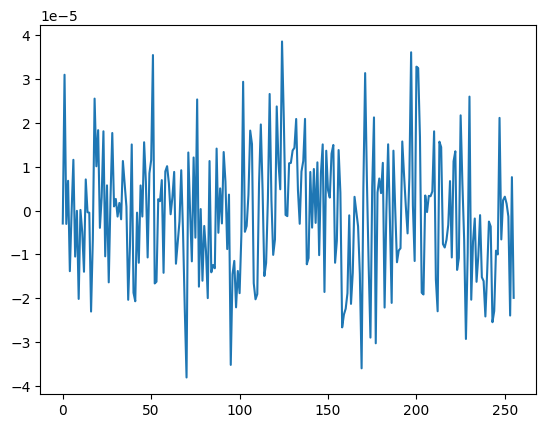

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(windows_ds[2][0][0,:].transpose()) # first channel of first epoch
plt.show()

In [28]:
from braindecode.datasets import BaseDataset, BaseConcatDataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.utils.data import TensorDataset

random_state = 42
torch.manual_seed(random_state)
eo_ec = np.array([ds[1] for ds in windows_ds]).transpose() # check labels
print("labels: ", eo_ec)

# Get balanced indices for male and female subjects
train_indices, test_indices = train_test_split(range(len(windows_ds)), test_size=0.2, stratify=eo_ec, random_state=random_state)

X_train = torch.FloatTensor(np.array([windows_ds[i][0] for i in train_indices]))  # Convert list of arrays to single tensor
X_test  = torch.FloatTensor(np.array([windows_ds[i][0] for i in test_indices]))  # Convert list of arrays to single tensor
y_train = torch.LongTensor(eo_ec[train_indices])     # Convert targets to tensor
y_test  = torch.LongTensor(eo_ec[test_indices])     # Convert targets to tensor
dataset_train = TensorDataset(X_train, y_train)
dataset_test  = TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=True)

# Print shapes and sizes to verify split
print(f"Shape of data {X_train.shape} number of samples - Train: {len(train_loader)}, Test: {len(test_loader)}")
print(f"EO/EC balance, train: {np.mean(eo_ec[train_indices]):.2f}, test: {np.mean(eo_ec[test_indices]):.2f}")

labels:  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Shape of data torch.Size([56, 24, 256]) number of samples - Train: 6, Test: 2
EO/EC balance, train: 0.50, test: 0.50


In [29]:
# visuzalize a batch of target labels
dataiter = iter(train_loader)
first_item, label = dataiter.__next__() # question why is the label lost here 
label

tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0])

In [30]:
# create model
import torch
from torchinfo import summary
from utils import *
from braindecode.models import ShallowFBCSPNet

np.random.seed(random_state)
torch.manual_seed(random_state)
model = ShallowFBCSPNet(
    24,
    2,
    input_window_samples=256,
    final_conv_length="auto",
)
print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 24, 256]              [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 24, 256]              [1, 24, 256, 1]           --                        --
├─Rearrange (dimshuffle): 1-2            [1, 24, 256, 1]           [1, 1, 256, 24]           --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 256, 24]           [1, 40, 232, 1]           39,440                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 232, 1]           [1, 40, 232, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 232, 1]           [1, 40, 232, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 232, 1]           [1, 40, 11, 1]            --                        [75, 1]
├─Express

/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/models/base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
/Users/arno/Python/EEG-Dash-Data/.venv/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [31]:

optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

model = model.to(device=device)  # move the model parameters to CPU/GPU
epochs = 6

def normalize_data(x):
    mean = x.mean(dim=2, keepdim=True)
    std = x.std(dim=2, keepdim=True) + 1e-7  # add small epsilon for numerical stability
    x = (x - mean) / std
    if 0:
        x = x.reshape(x.shape[0], 1, 24, 256)
    x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
    return x

def check_accuracy(scores, y, num_correct, num_samples):
    _, preds = scores.max(1)
    num_correct += (preds == y).sum()
    num_samples += preds.size(0)
    return num_correct, num_samples

for e in range(epochs):
    
    # training
    num_correct, num_samples = 0, 0
    for t, (x, y) in enumerate(train_loader):
        model.train()  # put model to training mode
        scores = model(normalize_data(x))
        loss = F.cross_entropy(scores, y.to(device=device, dtype=torch.long))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        num_correct, num_samples = check_accuracy(scores, y.to(device=device, dtype=torch.long), num_correct, num_samples)

        if t % 100 == 0:
            print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
    acc_train = num_correct / num_samples
    
    # validation
    num_correct, num_samples = 0, 0
    for t, (x, y) in enumerate(test_loader):
        model.eval()
        scores = model(normalize_data(x))
        num_correct, num_samples = check_accuracy(scores, y.to(device=device, dtype=torch.long), num_correct, num_samples)
        acc_test = num_correct / num_samples

    print(f'Epoch {e}, Train accuracy: {acc_train:.2f}, Test accuracy: {acc_test:.2f}')


Epoch 0, Iteration 0, loss = 0.6802
Epoch 0, Train accuracy: 0.52, Test accuracy: 0.50
Epoch 1, Iteration 0, loss = 0.5121
Epoch 1, Train accuracy: 0.82, Test accuracy: 0.50
Epoch 2, Iteration 0, loss = 0.3770
Epoch 2, Train accuracy: 0.91, Test accuracy: 0.64
Epoch 3, Iteration 0, loss = 0.2821
Epoch 3, Train accuracy: 0.93, Test accuracy: 0.64
Epoch 4, Iteration 0, loss = 0.1935
Epoch 4, Train accuracy: 0.88, Test accuracy: 0.64
Epoch 5, Iteration 0, loss = 0.3273
Epoch 5, Train accuracy: 0.96, Test accuracy: 0.71
